CSCI 4852 & 6952: Deep Learning (Spring 2023)  

Instructor: Alina Lazar (alazar@ysu.edu)  
GitHub repository:https://github.com/alinutzal/CSCI-xx52-Deep-Learning-
---

---

# Solving the XOR Problem

## Toy Dataset

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 123
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv('xor.csv')
X = df[['x1', 'x2']].values
y = df['class label'].values
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


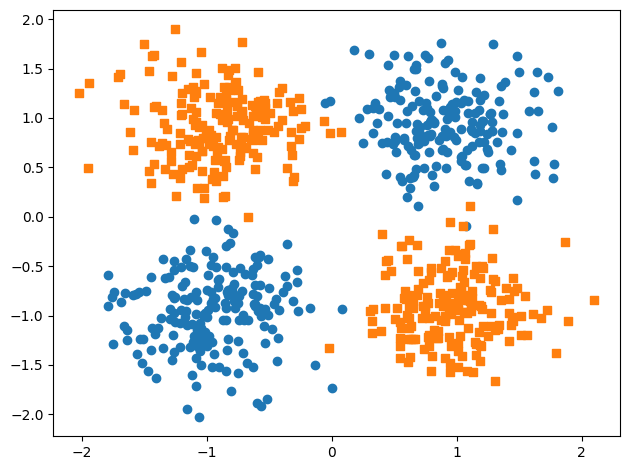

In [3]:
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], marker='s')

plt.tight_layout()
#plt.savefig('xor.pdf')
plt.show()

## Multilayer Perceptron with Linear Activations

In [4]:
class MLPLinear(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPLinear, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        #out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [5]:
torch.manual_seed(RANDOM_SEED)

model1 = MLPLinear(num_features=2,
                   num_hidden_1=50,
                   num_classes=2)

model1 = model1.to(DEVICE)

optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [6]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    logits, probas = model1(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()
    minibatch_cost.append(cost)
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING

    print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Cost: 0.7075
Epoch: 002/025 | Cost: 0.6980
Epoch: 003/025 | Cost: 0.6946
Epoch: 004/025 | Cost: 0.6933
Epoch: 005/025 | Cost: 0.6929
Epoch: 006/025 | Cost: 0.6928
Epoch: 007/025 | Cost: 0.6927
Epoch: 008/025 | Cost: 0.6927
Epoch: 009/025 | Cost: 0.6927
Epoch: 010/025 | Cost: 0.6927
Epoch: 011/025 | Cost: 0.6927
Epoch: 012/025 | Cost: 0.6927
Epoch: 013/025 | Cost: 0.6927
Epoch: 014/025 | Cost: 0.6927
Epoch: 015/025 | Cost: 0.6927
Epoch: 016/025 | Cost: 0.6927
Epoch: 017/025 | Cost: 0.6927
Epoch: 018/025 | Cost: 0.6927
Epoch: 019/025 | Cost: 0.6927
Epoch: 020/025 | Cost: 0.6927
Epoch: 021/025 | Cost: 0.6927
Epoch: 022/025 | Cost: 0.6927
Epoch: 023/025 | Cost: 0.6927
Epoch: 024/025 | Cost: 0.6927
Epoch: 025/025 | Cost: 0.6927
Total Training Time: 0.01 min


In [17]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y.cpu().numpy()))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)
    
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [18]:
plot_decision_regions(features.cpu(), targets.cpu(), classifier=model1.cpu())

plt.tight_layout()
#plt.savefig('xor1.pdf')
plt.show()

NameError: name 'colors' is not defined

<br>
<br>

## Multilayer Perceptron with Non-Linear Activations (Here: ReLU)

In [22]:
class MLPReLU(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPReLU, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [23]:
torch.manual_seed(RANDOM_SEED)

model2 = MLPReLU(num_features=2,
                num_hidden_1=50,
                num_classes=2)

model2 = model2.to(DEVICE)

optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [25]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    logits, probas = model2(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()
    minibatch_cost.append(cost)
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING

    print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Cost: 0.3508
Epoch: 002/025 | Cost: 0.3425
Epoch: 003/025 | Cost: 0.3344
Epoch: 004/025 | Cost: 0.3266
Epoch: 005/025 | Cost: 0.3191
Epoch: 006/025 | Cost: 0.3118
Epoch: 007/025 | Cost: 0.3048
Epoch: 008/025 | Cost: 0.2980
Epoch: 009/025 | Cost: 0.2915
Epoch: 010/025 | Cost: 0.2851
Epoch: 011/025 | Cost: 0.2790
Epoch: 012/025 | Cost: 0.2731
Epoch: 013/025 | Cost: 0.2674
Epoch: 014/025 | Cost: 0.2618
Epoch: 015/025 | Cost: 0.2565
Epoch: 016/025 | Cost: 0.2513
Epoch: 017/025 | Cost: 0.2463
Epoch: 018/025 | Cost: 0.2415
Epoch: 019/025 | Cost: 0.2368
Epoch: 020/025 | Cost: 0.2323
Epoch: 021/025 | Cost: 0.2279
Epoch: 022/025 | Cost: 0.2236
Epoch: 023/025 | Cost: 0.2195
Epoch: 024/025 | Cost: 0.2155
Epoch: 025/025 | Cost: 0.2117
Total Training Time: 0.00 min


In [26]:
plot_decision_regions(features, targets, classifier=model2)

plt.tight_layout()
#plt.savefig('xor2.pdf')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.